#### Tweet Sentiment Analysis
#### Dataset: https://www.kaggle.com/datasets/kazanova/sentiment140

In [96]:
import pandas as pd
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score
)
from sklearn.pipeline import Pipeline

### A. Data preparation and data cleaning
* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split


In [97]:
data_path = './training.1600000.processed.noemoticon.csv'
columns =['target','id','date','flag','user','text']
df = pd.read_csv(data_path, delimiter=',', header=None,encoding='latin-1', names=columns)

In [98]:
# Keep only target and text columns as other columns are not going to bring any value to our analysis
df = df[["target", "text"]]

print("Raw shape:", df.shape)
df.head()

Raw shape: (1600000, 2)


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


As the data size is too huge we will do sampling here

In [100]:
SAMPLE_SIZE = 200_000     
RANDOM_STATE = 42
df = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE).reset_index(drop=True)
print("\nAfter sampling:", df.shape)


After sampling: (200000, 2)


In [101]:
# Define mapping dictionaries
df["target"] = df["target"].map({
    0: 0,
    4: 1
})

In [102]:
URL_RE = re.compile(r"http\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
MULTI_SPACE_RE = re.compile(r"\s+")

def clean_text(text: str) -> str:
    text = text.lower()
    text = URL_RE.sub("", text)
    text = MENTION_RE.sub("", text)
    text = text.replace("#", " ")
    text = re.sub(r"[^a-z\s]", " ", text)
    text = MULTI_SPACE_RE.sub(" ", text).strip()
    return text

df["clean_text"] = df["text"].astype(str).apply(clean_text)
# Remove empty rows
df = df[df["clean_text"] != ""].reset_index(drop=True)

print("Final shape after cleaning:", df.shape)

Final shape after cleaning: (199508, 3)


### B. EDA, feature importance analysis

In [103]:
df["char_length"] = df["text"].apply(len)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

df[["char_length", "word_count"]].describe()

,char_length,word_count
count,199508.000000,199508.000000
mean,74.254852,13.212683
std,36.416043,6.948091
min,6.000000,1.000000
25%,44.000000,7.000000
50%,69.000000,12.000000
75%,104.000000,19.000000
max,313.000000,41.000000


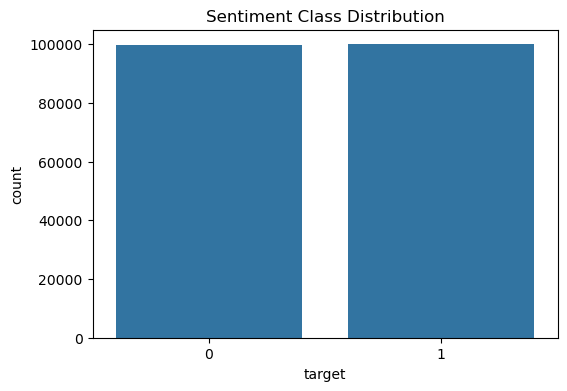

In [104]:
# Class Balance
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="target")
plt.title("Sentiment Class Distribution")
plt.show()

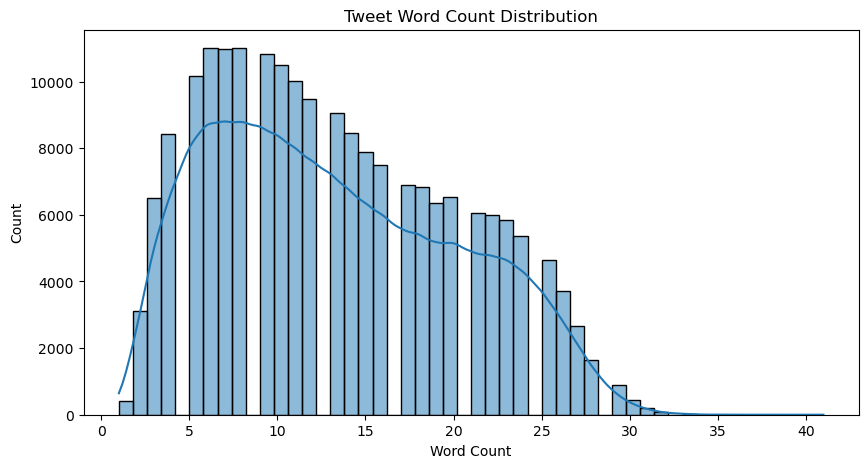

In [105]:
# Word Count Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["word_count"], bins=50, kde=True)
plt.title("Tweet Word Count Distribution")
plt.xlabel("Word Count")
plt.show()

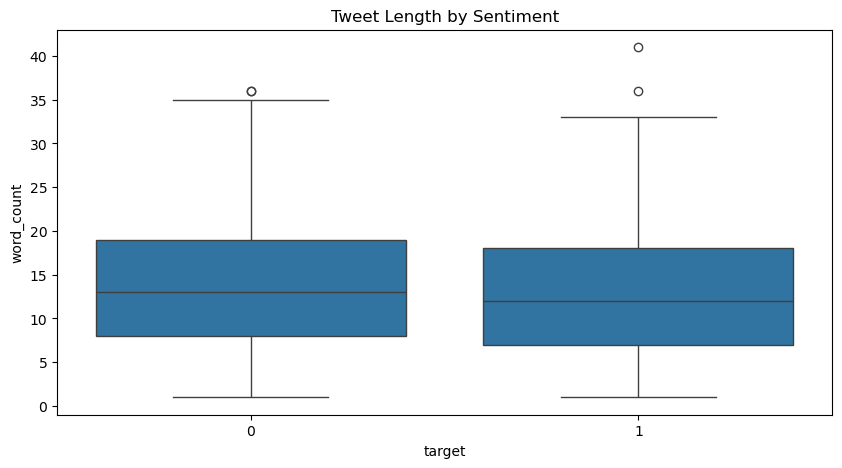

In [106]:
# Word Count by Sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="target", y="word_count")
plt.title("Tweet Length by Sentiment")
plt.show()

In [107]:
# Noise Analysis
df["has_url"] = df["text"].str.contains(r"http", regex=True)
df["has_mention"] = df["text"].str.contains(r"@", regex=False)
df["has_hashtag"] = df["text"].str.contains(r"#", regex=False)

round(df[["has_url", "has_mention", "has_hashtag"]].mean() * 100, 2)

has_url         4.39
has_mention    46.65
has_hashtag     2.32
dtype: float64

In [108]:
# Top Words (Raw Text)
def top_words(texts, n=20):
    return Counter(" ".join(texts).lower().split()).most_common(n)

top_pos = top_words(df[df["target"] == 1]["text"])
top_neg = top_words(df[df["target"] == 0]["text"])

top_pos, top_neg

([('i', 35966),
  ('the', 32747),
  ('to', 30936),
  ('a', 24712),
  ('you', 19403),
  ('and', 18328),
  ('my', 15342),
  ('for', 14645),
  ('is', 13245),
  ('in', 12234),
  ('it', 11512),
  ('of', 11165),
  ('on', 10038),
  ('with', 8085),
  ('have', 7827),
  ('that', 7770),
  ('just', 7677),
  ('so', 7649),
  ('me', 6931),
  ("i'm", 6916)],
 [('i', 57550),
  ('to', 38573),
  ('the', 31925),
  ('my', 23649),
  ('a', 22615),
  ('and', 18651),
  ('is', 15582),
  ('in', 14031),
  ('it', 12611),
  ('for', 12389),
  ('of', 11359),
  ('so', 10545),
  ('you', 10440),
  ('on', 10176),
  ('have', 10151),
  ('but', 9944),
  ("i'm", 9074),
  ('me', 8966),
  ('not', 8855),
  ('that', 8466)])

#### feature importance analysis

Minor preprocessing note:

Stemming and lemmatization were intentionally not applied. In combination with TF-IDF features, these techniques offered minimal performance improvement for short, informal text such as tweets, while reducing the interpretability of learned features. Preserving original word forms allows the Logistic Regression coefficients to remain directly human-readable (e.g., “happy”, “sad”), supporting clearer feature importance analysis.

In [109]:
vectorizer = TfidfVectorizer(
    stop_words="english",
)

In [110]:
# Feature Importance via Logistic Regression 
X = vectorizer.fit_transform(df["clean_text"])
y = df["target"]

model = LogisticRegression(max_iter=2000)
model.fit(X, y)

feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

top_positive = sorted(
    zip(feature_names, coefficients),
    key=lambda x: x[1],
    reverse=True
)[:20]

top_negative = sorted(
    zip(feature_names, coefficients),
    key=lambda x: x[1]
)[:20]

top_positive, top_negative

([('thanks', 4.889700431047986),
  ('thank', 4.431323398759248),
  ('congratulations', 4.165132806048117),
  ('glad', 4.026567690024695),
  ('welcome', 3.9976790275253133),
  ('smiling', 3.8215438044447447),
  ('awesome', 3.6283180968259234),
  ('yay', 3.6076682327892677),
  ('excited', 3.534059914617836),
  ('proud', 3.5202355586879777),
  ('cute', 3.4209698251517615),
  ('heh', 3.405738708316728),
  ('happy', 3.372165134985355),
  ('great', 3.3598731056584086),
  ('smile', 3.2756568170034432),
  ('blessed', 3.2737861478037913),
  ('cheers', 3.2159122692725255),
  ('amazing', 3.177164850332004),
  ('love', 3.134461391326263),
  ('hehe', 3.1210226398405627)],
 [('sad', -9.687769888546669),
  ('miss', -6.5099681772847395),
  ('bummed', -6.21345673796817),
  ('disappointed', -5.793549503460042),
  ('missing', -5.732397371049854),
  ('sick', -5.682056547830148),
  ('hate', -5.61425433686871),
  ('rip', -5.559437314212753),
  ('poor', -5.4748354229501235),
  ('upset', -5.400374653870629),


Words with the largest positive coefficients (e.g., *"thanks"*, *"awesome"*, *"happy"*, *"love"*) strongly increased the likelihood of a positive sentiment prediction.

Conversely, words with large negative coefficients (e.g., *"sad"*, *"miss"*, *"disappointed"*, *"failed"*) were highly indicative of negative sentiment.

This aligns well with intuitive human understanding of sentiment, confirming that the model captures meaningful emotional signals rather than spurious tokens.

#### Setting up the validation framework

In [111]:
X = df["clean_text"]
y = df["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    # keeps class balance
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])

Train size: 159606
Validation size: 39902


In [112]:
from sklearn.metrics import accuracy_score, f1_score

def get_metrics(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return {
        "Accuracy": accuracy_score(y_val, y_pred),
        "F1": f1_score(y_val, y_pred)
    }

In [113]:
results = []

##### Logistic Regression

In [114]:
logreg_baseline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("logreg", LogisticRegression(max_iter=2000))
])

results.append({
    "Model": "Logistic Regression (Baseline)",
    **get_metrics(logreg_baseline, X_train, y_train, X_val, y_val)
})

##### Linear SVM

In [115]:
svm_baseline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("svm", LinearSVC())
])

results.append({
    "Model": "Linear SVM (Baseline)",
    **get_metrics(svm_baseline, X_train, y_train, X_val, y_val)
})

c:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


#### Hyperparameter Tuning  

In this section, we fine-tune the hyperparameters of Logistic Regression, Linear SVM using Grid Search to improve accuracy, precision, recall, and F1-score.

The `ngram_range` parameter controls the size of word sequences used as features in the TF-IDF representation.
Unigrams capture individual word sentiment, while bigrams enable the model to learn sentiment-bearing phrases
such as negations (e.g., “not good”). Both `(1,1)` and `(1,2)` configurations were evaluated, with bigrams
often improving performance by capturing phrase-level sentiment cues.

In [116]:
logreg_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("logreg", LogisticRegression())
])

logreg_param_grid = {
    "tfidf__max_features": [10000, 20000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "logreg__C": [0.5, 1.0, 2.0],
    "logreg__max_iter": [1000, 2000]
}

logreg_grid = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train, y_train)

print("Best Logistic Regression params:")
print(logreg_grid.best_params_)
print("Best CV F1:", logreg_grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Logistic Regression params:
{'logreg__C': 1.0, 'logreg__max_iter': 1000, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Best CV F1: 0.771272245922337


In [117]:
logreg_tuned = logreg_grid.best_estimator_

results.append({
    "Model": "Logistic Regression (Tuned)",
    **get_metrics(logreg_tuned, X_train, y_train, X_val, y_val)
})

In [ ]:
svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("svm", LinearSVC())
])

svm_param_grid = {
    "tfidf__max_features": [10000, 20000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "svm__C": [0.5, 1.0, 2.0]
}

svm_grid = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train)

print("Best Linear SVM params:")
print(svm_grid.best_params_)
print("Best CV F1:", svm_grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best Linear SVM params:
{'svm__C': 0.5, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Best CV F1: 0.7639682772673599


In [119]:
svm_tuned = svm_grid.best_estimator_

results.append({
    "Model": "Linear SVM (Tuned)",
    **get_metrics(svm_tuned, X_train, y_train, X_val, y_val)
})

c:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [120]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1
0,Logistic Regression (Baseline),0.765350,0.770644
1,Linear SVM (Baseline),0.749787,0.753992
2,Logistic Regression (Tuned),0.767631,0.772912
3,Linear SVM (Tuned),0.761190,0.767285


As observed, Logistic Regression achieved the best overall performance, both before and after tuning. While Linear SVM benefited from hyperparameter optimization, it did not outperform Logistic Regression. Therefore, the tuned Logistic Regression model was selected as the final model.